In [1]:
import os 
import sys 
sys.path.append("../training")
import pickle
import copy
import time

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# Local imports
from save_data import process_data

In [2]:
START_WINDOW = 150
END_WINDOW = 550

RAW_DATA_DIR = f'../data/raw-data'
DATA_LOAD_DIR = f'../data/qick_data/{START_WINDOW}_{END_WINDOW}'
DATA_SAVE_DIR = f'../data/qick_data/{START_WINDOW}_{END_WINDOW}_shifted'

## 1. Load input data

In [3]:
# convert raw ADC data into npy files 
if os.path.exists(f'{DATA_LOAD_DIR}/X_train.npy') == False:
    process_data(
        start_window = START_WINDOW, 
        end_window = END_WINDOW, 
        data_in = RAW_DATA_DIR,
        data_out = DATA_LOAD_DIR
    )

# load data
X_train_val = np.load(os.path.join(DATA_LOAD_DIR, 'X_train.npy')).astype(np.float32)
X_test = np.load(os.path.join(DATA_LOAD_DIR, 'X_test.npy')) .astype(np.float32)   
y_train_val = np.load(os.path.join(DATA_LOAD_DIR, 'y_train.npy')).astype(np.float32)
y_test = np.load(os.path.join(DATA_LOAD_DIR, 'y_test.npy')).astype(np.float32)

print("Training:")
print("\tSize:", len(X_train_val))
print("\tSample Shape:", len(X_train_val[0]))
print("\tMean:", X_train_val.mean())
print("\tStd. Dev.:", X_train_val.std())

print("Testing:")
print("\tSize:", len(X_test))
print("\tSample Shape:", len(X_test[0]))
print("\tSample Shape:", X_test.mean())
print("\tStd. Dev.:", X_test.std())

# X_train_val[0] = I, Q timeseries over (END_WINDOW - START_WINDOW) timesteps
assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"

Training:
	Size: 909000
	Sample Shape: 800
	Mean: -27.768232
	Std. Dev.: 1757.3027
Testing:
	Size: 101000
	Sample Shape: 800
	Sample Shape: -21.301897
	Std. Dev.: 1755.5157


## 2. Functions to time-shift and zero-/noise-pad data 

In [4]:
def l_shift_data_zero_padded(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (0, offset*2)), mode='constant', constant_values=0)
    return extended_X[:,(start+offset)*2:(end+offset)*2]

def r_shift_data_zero_padded(X, start, end, offset):
    extended_X = np.pad(X, pad_width=((0, 0), (offset*2, 0)), mode='constant', constant_values=0)
    return extended_X[:,start*2:end*2]

def l_shift_data_noise_padded(X, start, end, offset, noise_lo = np.nan, noise_hi = np.nan):
    if offset == 0:
        return X[:,(start+offset)*2:(end+offset)*2]
    else:
        num_rows = X.shape[0]
        noise = np.random.uniform(noise_lo, noise_hi, size=(num_rows*offset*2)).astype(int)
        noise = noise.reshape(-1, offset*2)
        return np.hstack((X, noise))[:,(start+offset)*2:(end+offset)*2]

def r_shift_data_noise_padded(X, start, end, offset, noise_lo = np.nan, noise_hi = np.nan):
    if offset == 0:
        return X[:,start*2:end*2]
    else:
        num_rows = X.shape[0]
        noise = np.random.uniform(noise_lo, noise_hi, size=(num_rows*offset*2)).astype(int)
        noise = noise.reshape(-1, offset*2)
        return np.hstack((noise, X))[:,start*2:end*2]

SHIFT_FUNCTION_DICT = {("left", "zero"): l_shift_data_zero_padded,
                      ("right", "zero"): r_shift_data_zero_padded,
                      ("left", "noise"): l_shift_data_noise_padded,
                      ("right", "noise"): r_shift_data_noise_padded}

## 3. Time-shift and save data

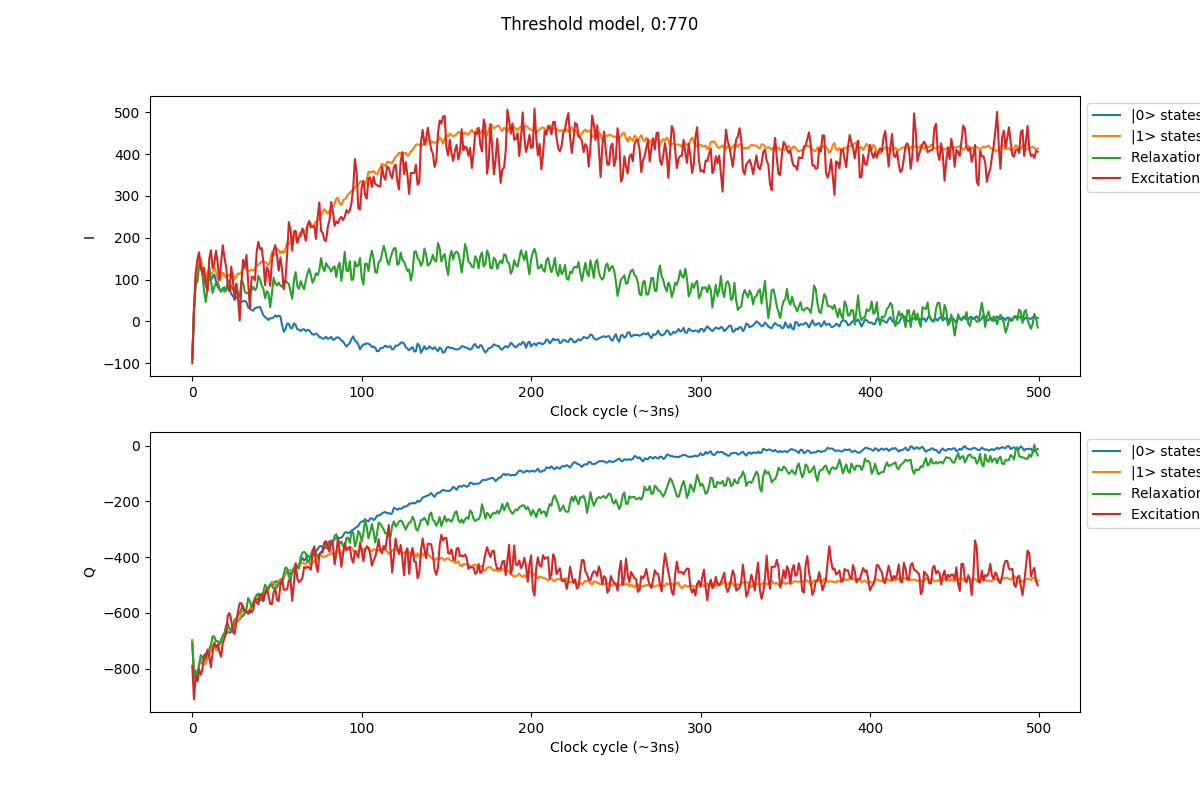

In [5]:
from IPython.display import Image
Image(os.path.join("transition_errors", "test", "thresh_traces.png"))

In [6]:
MAX_SHIFT = 200 #570
INCREMENT = 20
NOISE_LO = -4
NOISE_HI = 4

n_copies = 2*MAX_SHIFT//INCREMENT
n_tv_samples = n_copies*X_train_val.shape[0]
n_test_samples = n_copies*X_test.shape[0]

print(f"n_copies: {n_copies}")
print(f"n_tv_samples: {n_tv_samples:.3e}")
print(f"n_test_samples: {n_test_samples:.3e}")

n_copies: 20
n_tv_samples: 1.818e+07
n_test_samples: 2.020e+06


In [13]:
tic = time.time()

for padding in ["zero"]:#, "noise"]:
    
    for direction in ["right", "left"]:
        # Shift and save
        SAVE_DIR = os.path.join(DATA_SAVE_DIR, f"{direction}shift_{padding}padding_maxshift{MAX_SHIFT}_inc{INCREMENT}_noisem{np.abs(NOISE_LO)}p{NOISE_HI}")
        os.makedirs(SAVE_DIR, exist_ok = True)
        print(f"SAVE_DIR: {SAVE_DIR}")
        
        X_tv_p = copy.deepcopy(X_train_val)
        y_tv_p = copy.deepcopy(y_train_val)
        X_test_p = copy.deepcopy(X_test)
        y_test_p = copy.deepcopy(y_test)

        # Get time function, kwargs 
        time_shift_func = SHIFT_FUNCTION_DICT[(direction, padding)]
        if padding=="zero":
            kwargs = {}
        elif padding=="noise":
            kwargs = {"noise_lo": NOISE_LO,
                      "noise_hi": NOISE_HI}
        else:
            raise NotImplementedError("'padding' argument must be in ['zero', 'noise']")

        
        for offset in range(MAX_SHIFT+1):
            if offset%INCREMENT != 0:
                continue
            X_tv_p_shifted = time_shift_func(X_train_val, 0, END_WINDOW - START_WINDOW, offset, **kwargs)
            X_tv_p = np.concatenate((X_tv_p, X_tv_p_shifted), axis=0)
            y_tv_p = np.concatenate((y_tv_p, y_train_val), axis=0)
    
            X_test_p_shifted = time_shift_func(X_test, 0, END_WINDOW - START_WINDOW, offset, **kwargs)
            X_test_p  = np.concatenate((X_test_p, X_test_p_shifted), axis=0)
            y_test_p = np.concatenate((y_test_p, y_test), axis=0)
    
        np.save(os.path.join(SAVE_DIR, "X_train.npy"), X_tv_p)
        np.save(os.path.join(SAVE_DIR, "y_train.npy"), y_tv_p)
        np.save(os.path.join(SAVE_DIR, "X_test.npy"), X_test_p)
        np.save(os.path.join(SAVE_DIR, "y_test.npy"), y_test_p)
        print(f"Saved padding = {padding}, direction = {direction}")
    
toc = time.time()
dur = toc - tic
print(f"Duration: {dur//60} minutes, {dur%60} seconds")

SAVE_DIR: ../data/qick_data/150_550_shifted/rightshift_zeropadding_maxshift200_inc20_noisem4p4
Saved padding = zero, direction = right
SAVE_DIR: ../data/qick_data/150_550_shifted/leftshift_zeropadding_maxshift200_inc20_noisem4p4
Saved padding = zero, direction = left
Duration: 15.0 minutes, 37.465099811553955 seconds
